In [1]:
import tensorflow as tf
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt

from strawberryfields import ops

from qmlt.tf import CircuitLearner
from qmlt.tf.helpers import make_param

from sklearn.utils import shuffle
from sklearn.datasets import load_digits

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1418105120804803132
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 316735488
locality {
  bus_id: 1
}
incarnation: 9721991096072126072
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


### Preparing dataset

We install a data from 

In [4]:
def create_dataset(split=0.1):
    digits = load_digits()
    
    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)
    
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(x)*split)

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]

    return train_x, train_y, test_x, test_y

In [5]:
def create_dataset_binary(class0: int, class1=None, split=0.1):
    # загружаем датасет
    digits = load_digits()

    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)

    x0, y0 = x[y == class0], y[y == class0]
    y0 = np.zeros(len(y0))

    if class1 is not None:
        x1, y1 = x[y == class1], y[y == class1]
        y1 = np.ones(len(y1))
    else:
        x1, y1 = x[y != class0], y[y != class0]
        y1 = np.zeros(len(y1))

    x, y = np.vstack((x0, x1)), np.hstack([y0, y1])
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(y) * split)  # default ~10% for a test

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]

    return train_x, train_y, test_x, test_y

**code to visualize samples from the dataset**

In [6]:
def draw_samples(samples, samples_number: int) -> None:
    """
    Visualize an ordered amount of randomly chosen samples from a given dataset.
    :param dataset: A Dataset from which to take samples to visualize
    :param samples_number: A number of samples to visualize
    """

    if samples_number % 4 == 0:
        rows = samples_number//4
    else:
        rows = samples_number // 4 + 1

    if samples_number > 4:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            # print(index)
            # print(dataset.trainX.shape)
            axs[i // 4, i % 4].imshow(samples[index].reshape([8, 8]))
    else:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            # print(dataset.trainX[index].shape)
            axs[i % 4].imshow(samples[index].reshape([8, 8]))
            
    plt.show()

#     plt.savefig('Mnist/CNN/Digits.png')

## Quantum Neural Network Model

In [7]:
class Model:
    def __init__(self, params=None) -> None:
            self.params = [make_param(name='phi'+str(i), regularize=False, constant=.7, monitor=True) for i in range(43)]
            self.squeeze_rate, self.learner, self.clf_task = None, None, None
            self.lr, self.steps = None, None
            self.step = 0
            self.X, self.Y = None, None
            if params is not None:
                pass
            
    def myloss(circuit_output, targets):
        return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)


    def outputs_to_predictions(outpt):
        return tf.round(outpt)
    
    def circuit(self, X):
        
        params = self.params

        def shaper(x):
            """
            x - a single picture
            :param x: an array of pixels
            :return: shape and reshaped array of pixels
            """
            print(x)
            
            if x.shape[0] == 64:
                return 8, tf.reshape(x, [8, 8])
            elif x.shape[0] == 36:
                return 6, tf.reshape(x, [6, 6])
            elif x.shape[0] == 35:
                return 5, tf.reshape(x, [5, 5])
            elif x.shape[0] == 16:
                return 4, tf.reshape(x, [4, 4])
            elif x.shape[0] == 9:
                return 3, tf.reshape(x, [3, 3])
            elif x.shape[0] == 4:
                return 2, tf.reshape(x, [2, 2])

        def conv_3x3_layer(x, delta):
            """
            54 parameters
            :param x: input data with shape (4,)
            :param delta: parameters shift for the current layer
            :return: bosons amount in the 0's qumode.
            """
            eng, q = sf.Engine(9)

            with eng:
                ops.Sgate(1.5, x[:, 0]) | q[0]
                ops.Sgate(1.5, x[:, 1]) | q[1]
                ops.Sgate(1.5, x[:, 2]) | q[2]
                ops.Sgate(1.5, x[:, 3]) | q[3]
                ops.Sgate(1.5, x[:, 4]) | q[4]
                ops.Sgate(1.5, x[:, 5]) | q[5]
                ops.Sgate(1.5, x[:, 6]) | q[6]
                ops.Sgate(1.5, x[:, 7]) | q[7]
                ops.Sgate(1.5, x[:, 8]) | q[8]
                ops.BSgate(params[0 + delta], params[1 + delta]) | (q[0], q[1])
                ops.BSgate(params[2 + delta], params[3 + delta]) | (q[2], q[3])
                ops.BSgate(params[4 + delta], params[5 + delta]) | (q[4], q[5])
                ops.BSgate(params[6 + delta], params[7 + delta]) | (q[6], q[7])
                ops.Rgate(params[16 + delta]) | q[7]
                ops.BSgate(params[8 + delta], params[9 + delta]) | (q[7], q[8])
                ops.Rgate(params[17 + delta]) | q[1]
                ops.Rgate(params[18 + delta]) | q[2]
                ops.BSgate(params[10 + delta], params[11 + delta]) | (q[1], q[2])
                ops.Rgate(params[19 + delta]) | q[5]
                ops.Rgate(params[20 + delta]) | q[7]
                ops.BSgate(params[12 + delta], params[13 + delta]) | (q[5], q[7])
                ops.Rgate(params[21 + delta]) | q[5]
                ops.Rgate(params[22 + delta]) | q[2]
                ops.BSgate(params[14 + delta], params[15 + delta]) | (q[2], q[5])
                # ops.Rgate(params[16 + delta]) | q[0]
                # ops.Rgate(params[17 + delta]) | q[2]
                
            num_inputs = x.get_shape().as_list()[0]
            state = eng.run('tf', cutoff_dim=9, eval=False, batch_size=num_inputs)

#             eng = sf.Engine('fock', backend_options={'cutoff_dim': 5, 'eval': True})
#             result = eng.run(qnn)
#             state = result.state

            modes = 9*[0]
            modes[2] = 2
            p0 = state.fock_prob(modes)
            modes[2] = 0
            modes[5] = 2
            p1 = state.fock_prob(modes)

            normalization = p0 + p1 + 1e-10  # + p2
            output = p0 / normalization
            return output

        def conv_2x2_layer(x, delta):
            """
            54 parameters
            :param x: input data with shape (4,)
            :param delta: parameters shift for the current layer
            :return: bosons amount in the 0's qumode.
            """
            qnn = sf.Program(4)
            with qnn.context as q:
                ops.Sgate(1.5, x[:, 0]) | q[0]
                ops.Sgate(1.5, x[:, 1]) | q[1]
                ops.Sgate(1.5, x[:, 2]) | q[2]
                ops.Sgate(1.5, x[:, 3]) | q[3]
                ops.BSgate(params[0 + delta], params[1 + delta]) | (q[0], q[1])
                ops.BSgate(params[2 + delta], params[3 + delta]) | (q[2], q[3])
                ops.Rgate(params[4 + delta]) | q[0]
                ops.Rgate(params[5 + delta]) | q[2]
                ops.BSgate(params[6 + delta], params[7 + delta]) | (q[0], q[2])
                # ops.Rgate(params[8 + delta]) | q[0]
                
            num_inputs = x.get_shape().as_list()[0]
            state = eng.run('tf', cutoff_dim=10, eval=False, batch_size=num_inputs)

#             eng = sf.Engine('fock', backend_options={'cutoff_dim': 5, 'eval': True})
#             result = eng.run(qnn)
#             state = result.state

            p0 = state.fock_prob([2, 0, 0, 0])
            p1 = state.fock_prob([0, 2, 0, 0])

            normalization = p0 + p1 + 1e-10  # + p2
            output = p0 / normalization  # , p1 / normalization]  # , p2 / normalization]
            return output

        def make_matrixes_3x3(x):
            
            """
                идем матрицей 3х3 с шагом 1,
                тогда из мтарицы 8х8 получаем 6х6
            """
            axs_scale, _x = shaper(x)
            print('\n', _x, '\n')
            input_x = []
            for i in range(0, axs_scale-2, 1):  # x
                for j in range(0, axs_scale-2, 1):  # y
                    tensor = tf.gather_nd(_x, [[i, j], [i, j + 1], [i, j + 2],
                                             [i + 1, j], [i + 1, j + 1], [i + 1, j + 2],
                                             [i + 2, j], [i + 2, j + 1], [i + 2, j + 2]])
                    print('matrix to feed into conv ', tensor)
                    input_x.append(tensor)
                    
                    
#                     input_x.append(np.array([_x[i, j], _x[i, j + 1], _x[i, j + 2],
#                                              _x[i + 1, j], _x[i + 1, j + 1], _x[i + 1, j + 2],
#                                              _x[i + 2, j], _x[i + 2, j + 1], _x[i + 2, j + 2]
#                                              ]))

#             input_x = np.array(input_x)
#             output = 
            return input_x

        def make_matrixes_2x2(x, step):
            """
            картинка 8x8 -> маска 2х2 с шагом 1
            :param x:
            :return:
            """
            axs_scale, _x = shaper(x)
            input_x = []
            for i in range(0, axs_scale-1, step):  # x
                for j in range(0, axs_scale-1, step):  # y
                    input_x.append(np.array([_x[i, j], _x[i, j + 1], _x[i + 1, j], _x[i + 1, j + 1]]))

            input_x = np.array(input_x)
            return input_x

        def max_pooling_2x2(x):
            _x = make_matrixes_2x2(x, 2)
            return np.max(_x, axis=1)

        def full_con_layer(x, delta):

            eng, q = sf.Engine(4)
            # print('output layer')

            with eng:
                ops.Sgate(1.5, x[:, 0]) | q[0]
                ops.Sgate(1.5, x[:, 1]) | q[1]
                ops.Sgate(1.5, x[:, 2]) | q[2]
                ops.Sgate(1.5, x[:, 3]) | q[3]
                ops.BSgate(params[0 + delta], params[1 + delta]) | (q[0], q[1])
                ops.BSgate(params[2 + delta], params[3 + delta]) | (q[2], q[3])
                ops.BSgate(params[4 + delta], params[5 + delta]) | (q[1], q[2])
                # ops.Sgate(params[6 + delta]) | q[0]
                # ops.Sgate(params[7 + delta]) | q[1]
                # ops.Sgate(params[8 + delta]) | q[2]
                # ops.Sgate(params[9 + delta]) | q[3]
                # ops.MZgate(params[10 + delta], params[11 + delta]) | (q[0], q[1])
                # ops.MZgate(params[12 + delta], params[13 + delta]) | (q[2], q[3])
                # ops.MZgate(params[14 + delta], params[15 + delta]) | (q[1], q[2])
                ops.Rgate(params[6 + delta]) | q[1]
                ops.Rgate(params[7 + delta]) | q[2]
                # ops.Dgate(params[16 + delta]) | q[0]
                ops.Dgate(params[8 + delta]) | q[1]
                ops.Dgate(params[9 + delta]) | q[2]
                # ops.Dgate(params[19 + delta]) | q[3]
                # ops.Pgate(params[20 + delta]) | q[0]
                ops.Pgate(params[10 + delta]) | q[1]
                ops.Pgate(params[11 + delta]) | q[2]
                # ops.Pgate(params[23 + delta]) | q[3]
                
            num_inputs = x.get_shape().as_list()[0]
            state = eng.run('tf', cutoff_dim=10, eval=False, batch_size=num_inputs)

#             eng = sf.Engine('fock', backend_options={'cutoff_dim': 5, 'eval': True})
#             result = eng.run(qnn)
#             state = result.state

            p0 = state.fock_prob([0, 2, 0, 0])
            p1 = state.fock_prob([0, 0, 2, 0])

            normalization = p0 + p1 + 1e-10  # + p2
            output = p0 / normalization  # , p1 / normalization]  # , p2 / normalization]

            return output
        def make_3x3_conv(x):
            otput = conv_3x3_layer(x, 0)
            print(output)
            return output
                

        def single_circuit(x):  
            print(x, '\n')
            print('\nstarted making matricses to feed into convolution')
#             _x = np.array([make_matrixes_3x3(xx) for xx in x])
            
            _x = tf.map_fn(make_matrixes_3x3, x, dtype=[tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.float64,
                                                       tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.float64,
                                                       tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.float64,
                                                       tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.float64,
                                                       tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.float64,
                                                       tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.float64])
            _x = tf.stack(_x, axis=1, name='stack')
            print('\nstarted convolutions')
            print('testor_shape', _x.get_shape().as_list())
            print(_x)
            _x = tf.map_fn(make_3x3_conv, _x, dtype = tf.float64)
            print('\made convoltions')
            print(_x)
            print('\start_preparing_pooling_layer')
            _x = np.array([max_pooling_2x2(np.array(xx).flatten()) for xx in _x])
            _x = np.array([make_matrixes_2x2(np.array(_x).flatten(), 1) for xx in _x])
            _x = conv_2x2_layer(x=_x, delta=23)
            output = full_con_layer(np.array([np.array(xx).flatten() for xx in _x]), delta=31)
            return output

#         circuit_output = [_single_circuit(x) for x in X]
#         return circuit_output
        return single_circuit(X)

    def predict(self, data_to_predict) -> np.array:
        outcomes = self.learner.run_circuit(X=data_to_predict, outputs_to_predictions=self._outputs_to_predictions)
        predictions = outcomes['predictions']
        return predictions

    def fit(self, lr: float, sq: float, steps: int, clf_task: str, train_x: list, train_y: list) -> None:
        """
        В задаче сверточных сетей мы обучаем сверточную матрицу:
        :return:
        """
        self.lr, self.steps, self.squeeze_rate = lr, steps, sq
        if clf_task not in ['binary', 'multi']:
            raise DoesntMatchChosenTask(tasks_list=['binary', 'multi'], err_task=clf_task)
        else:
            self.clf_task = clf_task
        if self.clf_task == 'binary':
            hyperparams = {'circuit': self.circuit,
#                            'init_circuit_params': self.params,
                           'task': 'supervised',
                           'loss': self.myloss,
                           'optimizer': 'SGD',
                           'init_learning_rate': lr,
                           'log_every': 1,
                           'warm_start': False}

            self.learner = CircuitLearner(hyperparams=hyperparams)
            self.learner.train_circuit(X=train_x, Y=train_y, steps=steps)
            upload_params(file_name='Mnist/CNN/params.txt', input_name='CNN_params', data=self.params)

    def score_model(self, test_x: np.array, test_y: np.array) -> None:
        test_score = self.learner.score_circuit(X=test_x, Y=test_y, outputs_to_predictions=self._outputs_to_predictions)
        print("\nPossible scores to print: {}".format(list(test_score.keys())))
        print("Accuracy on test set: {}".format(test_score['accuracy']))
        print("Loss on test set: {}".format(test_score['loss']))

#         name = 'Mnist/CNN/results.txt'
#         with open(name, 'a') as file:
#             file.write('results on ' + str(datetime.datetime.now()) + ' : \n')
#             file.write('different convolutions:    %s.\n'%(2))
#             file.write('squeezing parameter:    %s.\n'%(self.squeeze_rate))
#             file.write('learning rate:     %s.\n'%(self.lr))
#             file.write('steps:     %s.\n'%(self.steps))
#             file.write("Accuracy on test set: {}".format(test_score['accuracy']) + '\n')
#             file.write("Loss on test set: {}".format(test_score['loss']) + '\n\n\n')

## Start of the learning

In [8]:
train_x, train_y, test_x, test_y = create_dataset_binary(class0=1, class1=9)

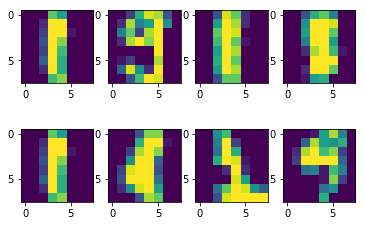

In [9]:
draw_samples(test_x, 8)

In [10]:
model = Model()
print('trainX = {}'.format(train_x.shape))
model.fit(lr=.35, sq=1.5, steps=10, clf_task='binary', train_x=train_x, train_y=train_y)
model.predict(data_to_predict=test_x)
model.score_model(test_x=test_x, test_y=test_y)

trainX = (326, 64)

----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.0 (default value)
init_learning_rate - 0.35
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - SGD
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True (default value)
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe3602886a0>, '_session_config': None, '_task_type': 'worker', '_service': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_globa

ValueError: Tensor("map_1/while/Beamsplitter/Reshape_3:0", shape=(1, 1, 1, 1, 1, 9), dtype=float32) must be from the same graph as Tensor("Cast_4:0", shape=(36, 1, 1, 1, 1, 1), dtype=float32).

In [ ]:
tensors = tf.constant(train_x)

In [ ]:
tensors

In [ ]:
for tensor in tensors.eval(session=tf.compat.Session()):
    print(tensor)

In [ ]:
params = [make_param(name='phi'+str(i), regularize=False, constant=.7, monitor=True) for i in range(43)]

def myloss(circuit_output, targets):
    return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)

def outputs_to_predictions(outpt):
    return tf.round(outpt)

def shaper(x):
    """
    x - a single picture
    :param x: an array of pixels
    :return: shape and reshaped array of pixels
    """
    print(x)

    if x.shape[0] == 64:
        return 8, tf.reshape(x, [8, 8])
    elif x.shape[0] == 36:
        return 6, np.array(x.reshape([6, 6]))
    elif x.shape[0] == 35:
        return 5, np.array(x.reshape([5, 5]))
    elif x.shape[0] == 16:
        return 4, np.array(x.reshape([4, 4]))
    elif x.shape[0] == 9:
        return 3, np.array(x.reshape([3, 3]))
    elif x.shape[0] == 4:
        return 2, np.array(x.reshape([2, 2]))

def conv_3x3_layer(x, delta):
    """
    54 parameters
    :param x: input data with shape (4,)
    :param delta: parameters shift for the current layer
    :return: bosons amount in the 0's qumode.
    """
    qnn = sf.Program(9)
    with qnn.context as q:
        ops.Sgate(x[:, 0], self.squeeze_rate) | q[0]
        ops.Sgate(x[:, 1], self.squeeze_rate) | q[1]
        ops.Sgate(x[:, 2], self.squeeze_rate) | q[2]
        ops.Sgate(x[:, 3], self.squeeze_rate) | q[3]
        ops.Sgate(x[:, 4], self.squeeze_rate) | q[4]
        ops.Sgate(x[:, 5], self.squeeze_rate) | q[5]
        ops.Sgate(x[:, 6], self.squeeze_rate) | q[6]
        ops.Sgate(x[:, 7], self.squeeze_rate) | q[7]
        ops.Sgate(x[:, 8], self.squeeze_rate) | q[8]
        ops.BSgate(params[0 + delta], params[1 + delta]) | (q[0], q[1])
        ops.BSgate(params[2 + delta], params[3 + delta]) | (q[2], q[3])
        ops.BSgate(params[4 + delta], params[5 + delta]) | (q[4], q[5])
        ops.BSgate(params[6 + delta], params[7 + delta]) | (q[6], q[7])
        ops.Rgate(params[16 + delta]) | q[7]
        ops.BSgate(params[8 + delta], params[9 + delta]) | (q[7], q[8])
        ops.Rgate(params[17 + delta]) | q[1]
        ops.Rgate(params[18 + delta]) | q[2]
        ops.BSgate(params[10 + delta], params[11 + delta]) | (q[1], q[2])
        ops.Rgate(params[19 + delta]) | q[5]
        ops.Rgate(params[20 + delta]) | q[7]
        ops.BSgate(params[12 + delta], params[13 + delta]) | (q[5], q[7])
        ops.Rgate(params[21 + delta]) | q[5]
        ops.Rgate(params[22 + delta]) | q[2]
        ops.BSgate(params[14 + delta], params[15 + delta]) | (q[2], q[5])
        # ops.Rgate(params[16 + delta]) | q[0]
        # ops.Rgate(params[17 + delta]) | q[2]

    num_inputs = x.get_shape().as_list()[0]
    state = eng.run('tf', cutoff_dim=10, eval=False, batch_size=num_inputs)

#             eng = sf.Engine('fock', backend_options={'cutoff_dim': 5, 'eval': True})
#             result = eng.run(qnn)
#             state = result.state

    modes = 9*[0]
    modes[2] = 2
    p0 = state.fock_prob(modes)
    modes[2] = 0
    modes[5] = 2
    p1 = state.fock_prob(modes)

    normalization = p0 + p1 + 1e-10  # + p2
    output = p0 / normalization
    return output

def conv_2x2_layer(x, delta):
    """
    54 parameters
    :param x: input data with shape (4,)
    :param delta: parameters shift for the current layer
    :return: bosons amount in the 0's qumode.
    """
    qnn = sf.Program(4)
    with qnn.context as q:
        ops.Sgate(x[:, 0], self.squeeze_rate) | q[0]
        ops.Sgate(x[:, 1], self.squeeze_rate) | q[1]
        ops.Sgate(x[:, 2], self.squeeze_rate) | q[2]
        ops.Sgate(x[:, 3], self.squeeze_rate) | q[3]
        ops.BSgate(params[0 + delta], params[1 + delta]) | (q[0], q[1])
        ops.BSgate(params[2 + delta], params[3 + delta]) | (q[2], q[3])
        ops.Rgate(params[4 + delta]) | q[0]
        ops.Rgate(params[5 + delta]) | q[2]
        ops.BSgate(params[6 + delta], params[7 + delta]) | (q[0], q[2])
        # ops.Rgate(params[8 + delta]) | q[0]

    num_inputs = x.get_shape().as_list()[0]
    state = eng.run('tf', cutoff_dim=10, eval=False, batch_size=num_inputs)

#             eng = sf.Engine('fock', backend_options={'cutoff_dim': 5, 'eval': True})
#             result = eng.run(qnn)
#             state = result.state

    p0 = state.fock_prob([2, 0, 0, 0])
    p1 = state.fock_prob([0, 2, 0, 0])

    normalization = p0 + p1 + 1e-10  # + p2
    output = p0 / normalization  # , p1 / normalization]  # , p2 / normalization]
    return output

def make_matrixes_3x3(x):

    """
        идем матрицей 3х3 с шагом 1,
        тогда из мтарицы 8х8 получаем 6х6
    """
    axs_scale, _x = shaper(x)
    print('\n', _x, '\n')
    input_x = []
    for i in range(0, axs_scale-2, 1):  # x
        for j in range(0, axs_scale-2, 1):  # y
            tensor = tf.gather_nd(_x, [[i, j], [i, j + 1], [i, j + 2],
                                     [i + 1, j], [i + 1, j + 1], [i + 1, j + 2],
                                     [i + 2, j], [i + 2, j + 1], [i + 2, j + 2]])
            print(tensor)
            input_x.append(tensor)

#                     input_x.append(np.array([_x[i, j], _x[i, j + 1], _x[i, j + 2],
#                                              _x[i + 1, j], _x[i + 1, j + 1], _x[i + 1, j + 2],
#                                              _x[i + 2, j], _x[i + 2, j + 1], _x[i + 2, j + 2]
#                                              ]))

    input_x = np.array(input_x)
    return input_x

def make_matrixes_2x2(x, step):
    """
    картинка 8x8 -> маска 2х2 с шагом 1
    :param x:
    :return:
    """
    axs_scale, _x = shaper(x)
    input_x = []
    for i in range(0, axs_scale-1, step):  # x
        for j in range(0, axs_scale-1, step):  # y
            input_x.append(np.array([_x[i, j], _x[i, j + 1], _x[i + 1, j], _x[i + 1, j + 1]]))

    input_x = np.array(input_x)
    return input_x

def max_pooling_2x2(x):
    _x = make_matrixes_2x2(x, 2)
    return np.max(_x, axis=1)

def full_con_layer(x, delta):

    qnn = sf.Program(4)
    # print('output layer')

    with qnn.context as q:
        ops.Sgate(x[:, 0], self.squeeze_rate) | q[0]
        ops.Sgate(x[:, 1], self.squeeze_rate) | q[1]
        ops.Sgate(x[:, 2], self.squeeze_rate) | q[2]
        ops.Sgate(x[:, 3], self.squeeze_rate) | q[3]
        ops.BSgate(params[0 + delta], params[1 + delta]) | (q[0], q[1])
        ops.BSgate(params[2 + delta], params[3 + delta]) | (q[2], q[3])
        ops.BSgate(params[4 + delta], params[5 + delta]) | (q[1], q[2])
        # ops.Sgate(params[6 + delta]) | q[0]
        # ops.Sgate(params[7 + delta]) | q[1]
        # ops.Sgate(params[8 + delta]) | q[2]
        # ops.Sgate(params[9 + delta]) | q[3]
        # ops.MZgate(params[10 + delta], params[11 + delta]) | (q[0], q[1])
        # ops.MZgate(params[12 + delta], params[13 + delta]) | (q[2], q[3])
        # ops.MZgate(params[14 + delta], params[15 + delta]) | (q[1], q[2])
        ops.Rgate(params[6 + delta]) | q[1]
        ops.Rgate(params[7 + delta]) | q[2]
        # ops.Dgate(params[16 + delta]) | q[0]
        ops.Dgate(params[8 + delta]) | q[1]
        ops.Dgate(params[9 + delta]) | q[2]
        # ops.Dgate(params[19 + delta]) | q[3]
        # ops.Pgate(params[20 + delta]) | q[0]
        ops.Pgate(params[10 + delta]) | q[1]
        ops.Pgate(params[11 + delta]) | q[2]
        # ops.Pgate(params[23 + delta]) | q[3]

    num_inputs = x.get_shape().as_list()[0]
    state = eng.run('tf', cutoff_dim=10, eval=False, batch_size=num_inputs)

#     eng = sf.Engine('fock', backend_options={'cutoff_dim': 5, 'eval': True})
#     result = eng.run(qnn)
#     state = result.state

    p0 = state.fock_prob([0, 2, 0, 0])
    p1 = state.fock_prob([0, 0, 2, 0])

    normalization = p0 + p1 + 1e-10  # + p2
    output = p0 / normalization  # , p1 / normalization]  # , p2 / normalization]

    return output

def circuit(self, X):
    x = X
    print(x)
    _x = tf.map_fn(make_matrixes_3x3, x, dtype=(tf.float64))
    _x = conv_3x3_layer(x=_x, delta=0)
    print(_x)
    _x = np.array([max_pooling_2x2(np.array(xx).flatten()) for xx in _x])
    _x = np.array([make_matrixes_2x2(np.array(_x).flatten(), 1) for xx in _x])
    _x = conv_2x2_layer(x=_x, delta=23)
    output = full_con_layer(np.array([np.array(xx).flatten() for xx in _x]), delta=31)
    return output

def predict(self, data_to_predict) -> np.array:
    outcomes = self.learner.run_circuit(X=data_to_predict, outputs_to_predictions=self._outputs_to_predictions)
    predictions = outcomes['predictions']
    return predictions

def fit(self, lr: float, sq: float, steps: int, clf_task: str, train_x: list, train_y: list) -> None:
    """
    В задаче сверточных сетей мы обучаем сверточную матрицу:
    :return:
    """
    self.lr, self.steps, self.squeeze_rate = lr, steps, sq
    if clf_task not in ['binary', 'multi']:
        raise DoesntMatchChosenTask(tasks_list=['binary', 'multi'], err_task=clf_task)
    else:
        self.clf_task = clf_task
    if self.clf_task == 'binary':
        hyperparams = {'circuit': self.circuit,
#                            'init_circuit_params': self.params,
                       'task': 'supervised',
                       'loss': self.myloss,
                       'optimizer': 'SGD',
                       'init_learning_rate': lr,
                       'log_every': 1,
                       'warm_start': False}

        self.learner = CircuitLearner(hyperparams=hyperparams)
        self.learner.train_circuit(X=train_x, Y=train_y, steps=steps)
        upload_params(file_name='Mnist/CNN/params.txt', input_name='CNN_params', data=self.params)

def score_model(self, test_x: np.array, test_y: np.array) -> None:
    test_score = self.learner.score_circuit(X=test_x, Y=test_y, outputs_to_predictions=self._outputs_to_predictions)
    print("\nPossible scores to print: {}".format(list(test_score.keys())))
    print("Accuracy on test set: {}".format(test_score['accuracy']))
    print("Loss on test set: {}".format(test_score['loss']))